In [8]:
import matplotlib.pyplot as plt
import decimal
import os
import re

In [9]:
def translate_position(position):
    
    if isinstance(position,str):  #name to position
        with open("positions.txt", "r") as f:
            content = f.read()
            if position in content:
                for line in content.splitlines():
                    if line.upper().startswith(position.upper()):
                        p = len(position)+3
                        name = line[p:-1]
            else:
                name = position
    
    else:   #position to name
        with open("positions.txt", "r") as f:
            content = f.read()
            pos = str(position)
            if pos in content:
                for line in content.splitlines():
                    if pos in line:
                        p = line.find(' :')
                        name = line[:p]
            else:
                name = 'P_X'+str(round(position[0], ndigits = 4))+'_Y'+str(round(position[1], ndigits = 4))+'_Z'+str(round(float(position[2]), ndigits = 4))
                name = name.replace(".", "_")
                with open("positions.txt", "a") as pos_file:
                    pos_file.write(f"{name} : {position} \n")
    
    return name

In [10]:
def extract_plan(method, path_file):
    plan = []
    plan_line = False
    already = False
    i = 0
    f = open(path_file, 'r')
    n = len(f.read().splitlines())

    with open(path_file, 'r') as file:
        for line in file:
            if plan_line == True and line.strip():
                if method == 'ff':
                    if line.startswith('step'):
                        line = line.replace('step', '')
                    elif line.startswith('time spent:') and already:
                        plan_line = False
                        continue
                lin = line.strip().replace('\n', '')
                plan.append(lin)

            if method == "lpg":
                if line.startswith('Plan computed') and not already:
                    i = 1
                elif i == 1 and not already:
                    plan_line = True
                    already = True

                if not line.strip() and already:
                    plan_line = False

            elif method == "sgplan":
                if line.startswith('; PlanningTechnique') and not already:
                    plan_line = True
                    already = True

            elif method == "optic":
                if line.startswith(';;;; Solution Found') and not already:
                    i = 1
                elif i > 0 and not already:
                    i = i+1
                if i == 4:
                    plan_line = True
                    already = True
                    
            elif method == 'ff':
                if line.startswith('ff: found legal plan as follows') and not already:
                    plan_line = True
                    already = True

            elif method.upper() == 'LAMA**':
                if i == n-2:
                    plan_line = False
                    already = True
                else:
                    if i ==0:
                        lin = line.strip().replace('\n', '')
                        plan.append(lin)
                        plan_line = True
                        i = i+1
                    else:
                        plan_line = True
                        i = i+1

    return plan


def info_from_plan(plan, meth):
    
    time_plan = []
    action_plan = []
    act_plan = []
    duration_plan = []
    id = []
    id_action = []
    duration = []
    interval = []
    plan_split = []
    act_tr = []
    cont = 0

    for i in range(0,len(plan)):
        if meth == "sgplan":
            cont = cont+1
            end_t = plan[i].index(':')
            t = plan[i][:end_t]
            exp = decimal.Decimal(t).as_tuple().exponent
            d = 10**(exp)
            tim = float(t)-(d*cont)
            time_plan.append(round(tim, abs(exp)))
        elif meth == 'lama**':
            end_t = plan[i].index('.')+3
            t = plan[i][:end_t]
            time_plan.append(float(t))
        else:
            end_t = plan[i].index(':')
            time_plan.append(float(plan[i][:end_t]))
        
        # Action -> (id, action)
        if '(' in plan[i] and not(meth=='lama**'):
            in_a = plan[i].index('(')
            end_a = plan[i].index(')')+1
            str_act = [plan[i][in_a+1:end_a-1]]
                        
            point = re.findall(r"P_X+\d+\_\d+_Y+\d+\_\d+_Z+\d+\_\d+", str_act[0])
            for k in range(0, len(point)):
                p = translate_position(point[k])
                p = p.replace(' ','')
                str_act[0] = str_act[0].replace(point[k], p)

            act_plan.append(str_act[0].split())
            action_plan.append((str_act[0]))
        elif meth == 'lama**':
            str_act = [plan[i][plan[i].index(')')+2:]]
            point = re.findall(r"p_x+\d+\_\d+_y+\d+\_\d+", str_act[0])
            for k in range(0, len(point)):
                p = translate_position(point[k])
                p = p.replace(' ','')+']'
                str_act[0] = str_act[0].replace(point[k], p)
            
            act_plan.append(str_act[0].split())
            action_plan.append((str_act[0]))
            
        else: 
            str_act = [plan[i][end_t+2:]]
            point = re.findall(r"p_x+\d+\_\d+_y+\d+\_\d+", str_act[0])
            for k in range(0, len(point)):
                p = translate_position(point[k])
                p = p.replace(' ','')+']'
                str_act[0] = str_act[0].replace(point[k], p)
            
            act_plan.append(str_act[0].split())
            action_plan.append((str_act[0]))

        act = act_plan[i]
        ids = act[1].upper()
        id.append(ids.upper())
        id_action.append((ids, action_plan[i]))
        
        
        # Duration -> (duration, cost) or duration
        # Interval -> (ini_time, ini_time+duration)
        if '[' in plan[i]:
            in_d = plan[i].index('[')+1
            end_d = plan[i].index(']')
            str_dur = plan[i][in_d:end_d]
            duration_plan.append(str_dur.split())

            if len(duration_plan[i]) > 1:
                dur = duration_plan[i]
                in_dur = dur[0].index('D:')+2
                end_dur = dur[0].index(';')
                in_c = dur[1].index('C:')+2
                d = float(dur[0][in_dur:end_dur])
                c = float(dur[1][in_c:])
                duration.append((d, c))
                interval.append((time_plan[i], time_plan[i]+d))
            else: 
                duration.append(float(duration_plan[i][0]))
                interval.append((time_plan[i], time_plan[i]+float(duration_plan[i][0])))
        elif meth == 'lama**':
            in_d = plan[i].index('(')+1
            end_d = plan[i].index(')')
            str_dur = plan[i][in_d:end_d]
            duration_plan.append(str_dur.split())
            duration.append(float(duration_plan[i][0]))
            interval.append((time_plan[i], time_plan[i]+float(duration_plan[i][0])))

        else: 
            duration.append(float(1.0))
            interval.append((time_plan[i], time_plan[i]+float(1.0)))
        
    for a in action_plan:
        if '_ONBOARD_ACTION' in a:
                aa = a.replace('_ONBOARD_ACTION','')
                act_tr.append(aa)
        elif '_ONGROUND_ACTION' in a:
                aa = a.replace('_ONGROUND_ACTION','')
                act_tr.append(aa)
        elif a.startswith('MOVE'):
                  b = a.split(' ')
                  aa = a.replace(b[0], 'MOVETO')
                  act_tr.append(aa)
        else:
                act_tr.append(a)
    
    plan_split = [[interval[i], act_tr[i]]for i in range(len(act_tr))]

    return action_plan, act_plan, act_tr, id, id_action, interval, duration, plan_split

def generate_dict(action, interval):
    action_dict = {}        
    for x, act in enumerate(action):
        if act in action_dict:
            action_dict[act].append(interval[x])
        else:
            action_dict[act] = [interval[x]]
    return action_dict

def plot_action_dict(planID, action_dict):
    keys = list(action_dict.keys())

    fig, ax = plt.subplots(figsize=(15,10))

    mx = 0
    for k in keys:
        for i in range(0,len(action_dict[k])):
            intvl = list(action_dict[k][i])
            if intvl[1] > mx:
                mx = intvl[1]
            ax.plot([intvl[0], intvl[1]], [keys.index(k)*0.5,keys.index(k)*0.5], color ='black', linewidth=15, solid_capstyle='butt')

    ax.set_xlim(-0.2,mx+0.2)
    ax.set_ylim(-0.25,(len(keys)-1)*0.5+0.25)

    y_ticks = [i*0.5 for i in range(len(keys))]

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(keys, fontdict={'fontsize': 12})

    ax.tick_params(axis='y', which='major', pad=15)

    ax.set_xlabel("Time (mins)", fontdict={'fontsize': 16})
    ax.set_ylabel("Actions", fontdict={'fontsize': 16})
    ax.set_title(planID, fontdict={'fontsize': 20, 'fontweight': 'bold'}, loc='center')

    if not os.path.exists('results'):
        os.mkdir('results')
    path_save = os.path.join('results', planID+'.png')
    fig.tight_layout()
    fig.savefig(path_save,bbox_inches='tight', pad_inches=0.2)

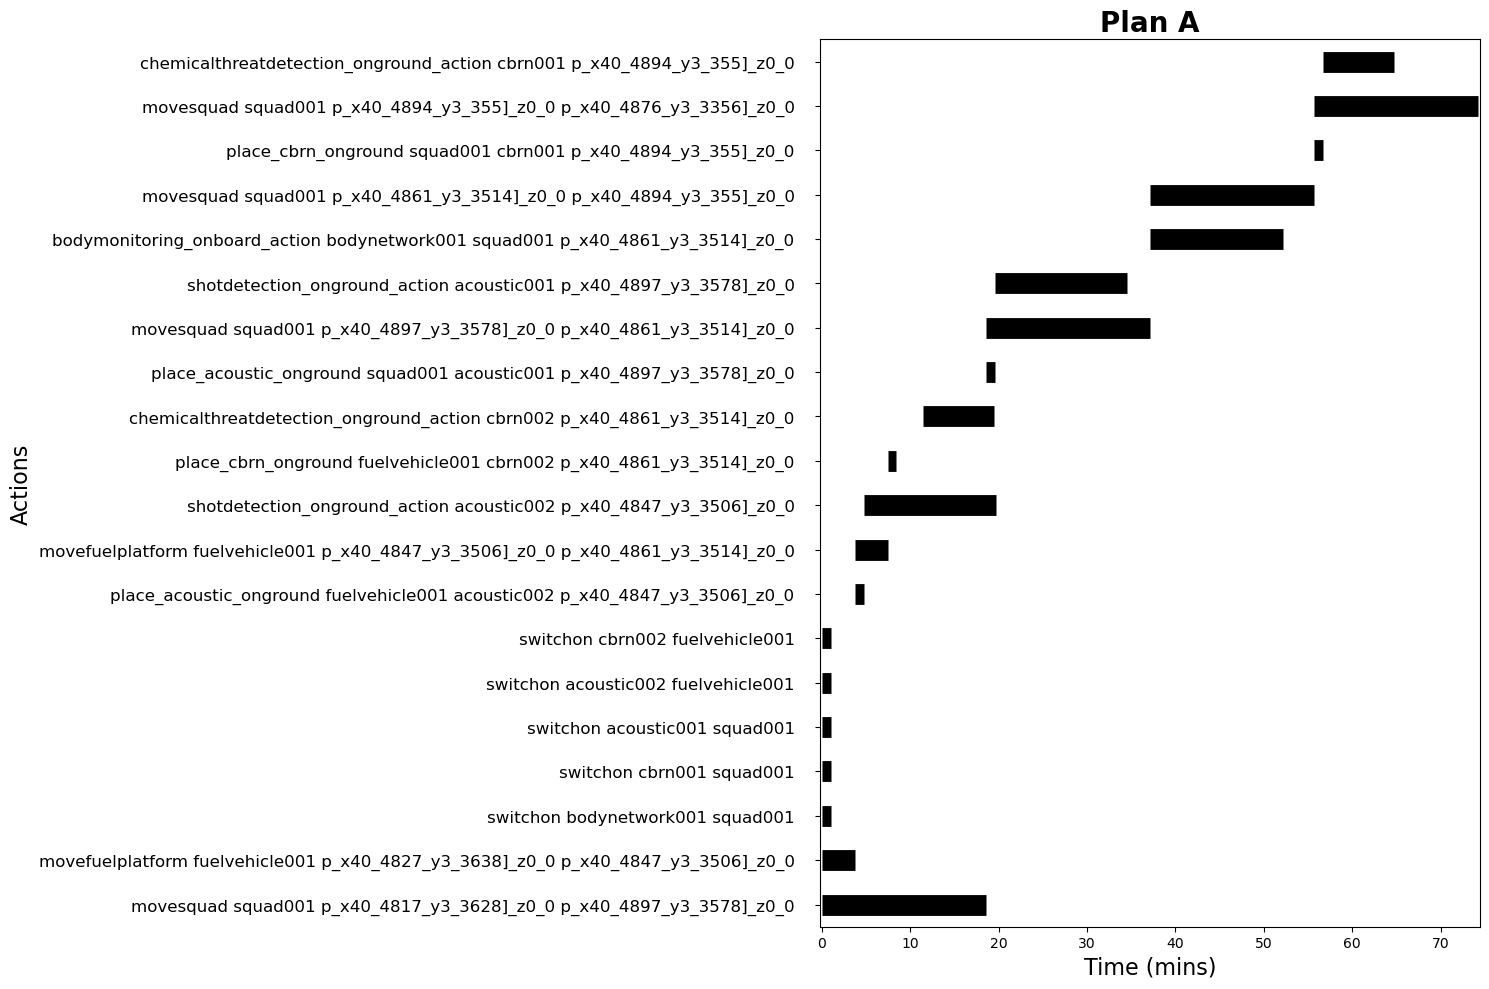

In [11]:
method = 'lama**'
path_file = "final_plan.txt"
planID = "Plan A"
plan = extract_plan(method, path_file)
action_plan, act_plan, act_tr, id, id_action, interval, duration, plan_split = info_from_plan(plan, method)
action_dict = generate_dict(act_tr, interval)
plot_action_dict(planID, action_dict)